# Library preparation of click coumpounds with BBB permeability  
This notebook describes library construction via virtual click chemistry with logBB calculation

- [Load and filter azides](#section1)
- [Run click-reaction](#section2)
- [Add logBB and permeability](#section3)
- [Add tanimoto similarity](#section4)
- [Create and save dataset](#section5)
- [Exploratory analysis](#section6)
- [logBB for scaffold and eticlopride](#section7)

In [1]:
from rdkit import Chem, DataStructs
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Draw
from rdkit import RDConfig
from rdkit.Chem import AllChem
from rdkit.Chem import rdChemReactions
import rdkit.Chem.Lipinski as Lipinksy
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import IPythonConsole 
from IPython.display import display, Image

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from collections import defaultdict

**The scaffold of interest:**

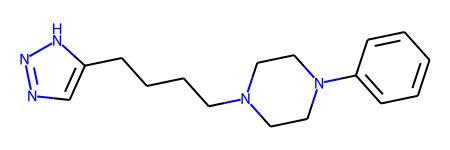

In [2]:
# an example of molecule drawing
scaffold = Chem.MolFromSmiles('N1N=NC=C1CCCCN1CCN(CC1)C1=CC=CC=C1')
scaffold

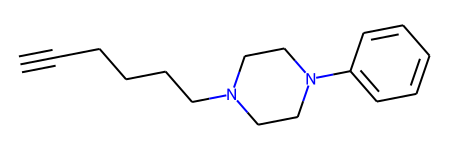

In [3]:
# the alkyne for click-reaction
alkyne = Chem.MolFromSmiles('C#CCCCCN2CCN(c1ccccc1)CC2')
alkyne

<a id='section1'></a>
## Load and filter azides
**Load azide smiles:**

In [4]:
# read lines from ZINC azide compound library

with open('data/azides.txt', 'r') as f:
    records = f.readlines()
print(f'Loaded {len(records)} azide records from file')

Loaded 143075 azide records from file


In [5]:
# filter azide smiles

azides = []

filtered = 0
no_azide = 0
more_than_one_azide = []

for smi in records:
    smi = smi.strip()
    if (len(smi) < 30) and (len(smi) > 10) and not ('.' in smi):
        if 'N=[N+]=[N-]' in smi:
            if smi.count('N=[N+]=[N-]') == 1:
                azides.append(smi)
            else:
                more_than_one_azide.append(smi)
        else:
            no_azide += 1
    else:
        filtered += 1
            
print(f'Filtered {len(azides)} SMILES structures ({len(azides)*100/len(records)}% of all loaded smiles)')
print(f"Dropped {filtered} molecules by smiles")
print(f"Dropped {len(more_than_one_azide)} molecules with more than one azide moiety")
print(f"Dropped {no_azide} molecules with no azide moiety")

Filtered 9783 SMILES structures (6.837672549362223% of all loaded smiles)
Dropped 132818 molecules by smiles
Dropped 40 molecules with more than one azide moiety
Dropped 434 molecules with no azide moiety


In [7]:
# save filtered azides
with open('data/azides_filtered.txt', 'w') as f:
    for mol in azides:
        f.write(f'{mol}\n')

<a id='section2'></a>
## Run click-reaction
**Run click reaction on filtered molecules:**

In [8]:
# reload azides
azides = []
with open('data/azides_filtered.txt', 'r') as f:
    for mol in f:
        azides.append(mol.strip())
        
print(f"Loaded {len(azides)} azide molecules")

Loaded 9783 azide molecules


In [52]:
# check the uniquieness of molecules in this library
azides = list(set(azides))
print(f"After leaving unique smiles only got {len(azides)} molecules")

After leaving unique smiles only got 9776 molecules


In [53]:
# define click-reaction pattern
rxn_both = rdChemReactions.ReactionFromSmarts('[*:6][N:1]=[N:2]=[N:3].[C:4]#[C:5]>>[*:6][N:1]1[N:2]=[N:3][C:4]=[C:5]1')
rxn_15 = rdChemReactions.ReactionFromSmarts('[*:6][N:1]=[N:2]=[N:3].[#6:7][C:4]#[C:5]>>[*:6][N:1]1[N:2]=[N:3][C:4]=[C:5]1[#6:7]')
rxn_14 = rdChemReactions.ReactionFromSmarts('[*:6][N:1]=[N:2]=[N:3].[#6:7][C:4]#[C:5]>>[*:6][N:1]([N:2]=[N:3]1)[C:5]=[C:4]1[#6:7]')


# neutralize molecue after reaction
def neutralize_atoms(mol):
    pattern = Chem.MolFromSmarts("[N-]=[N+]")
    at_matches = mol.GetSubstructMatches(pattern)
    if len(at_matches) > 0:
        at_matches_list = [at_matches[0][0], at_matches[0][1]]
        for at_idx in at_matches_list:
            atom = mol.GetAtomWithIdx(at_idx)
            atom.SetFormalCharge(0)
            atom.UpdatePropertyCache()
    return mol

# check Lipinski rules
def checkLip(molecule): 
    return bool((Lipinksy.NumHDonors(molecule) <= 5) and (Lipinksy.NumHAcceptors(molecule) <= 10) \
    and (Lipinksy.rdMolDescriptors.CalcExactMolWt(molecule) < 500) \
    and(Lipinksy.rdMolDescriptors.CalcCrippenDescriptors(molecule)[0]) <= 5)

# a function to run reaction
def click_reaction(azide, alkyne, isomer='both'):
    # define reactants
    reactants = (Chem.MolFromSmiles(azide),
                 Chem.MolFromSmiles(alkyne))
    
    if isomer == 'both':
        out = rxn_both.RunReactants(reactants) # run reaction
    elif isomer == '14':
        out = rxn_14.RunReactants(reactants) # run reaction
    elif isomer == '15':
        out = rxn_15.RunReactants(reactants) # run reaction
    
    products = [neutralize_atoms(mol[0]) for mol in out] # nutralize charges in products

    return products

In [70]:
# now run reaction with template alkyne for all filtered azides
alkyne = 'C#CCCCCN2CCN(c1ccccc1)CC2'

reaction_products = [] # a list to append newly constructed molecules
isomers14, isomers15 = 0, 0
filtered_by_lipinski = 0
failed_to_generate = []

for azide in tqdm(azides, desc="Running click-reaction"):
    
    try:
        # get 1,4 product
        product_14 = click_reaction(azide, alkyne, isomer='14')[0]
        product_14 = Chem.MolFromSmiles(Chem.MolToSmiles(product_14))
        if checkLip(product_14):
            # add smiles and a marker indicating if it is 1,4-isomer
            reaction_products.append([Chem.MolToSmiles(product_14), 1])
            isomers14 += 1
        else:
            filtered_by_lipinski += 1
    except:
        failed_to_generate.append(azide)
        
    try:
        # get 1,5 product
        product_15 = click_reaction(azide, alkyne, isomer='15')[0]
        product_15 = Chem.MolFromSmiles(Chem.MolToSmiles(product_15))
        if checkLip(product_15):
            # add smiles and a marker indicating if it is 1,4-isomer
            reaction_products.append([Chem.MolToSmiles(product_15), 0])
            isomers15 += 1
        else:
            filtered_by_lipinski += 1
    except:
        failed_to_generate.append(azide)
    
    
print(f'Constructed {len(reaction_products)} compounds')
print(f'{isomers14} 1,4-isomers and {isomers15} 1,5-isomers')
print(f'Failed to generate {len(failed_to_generate)} molecules')
print(f'{filtered_by_lipinski} Molecules did not pass Lipinski filter')

Running click-reaction:  53%|█████▎    | 5139/9776 [00:12<00:11, 420.54it/s]RDKit ERROR: [15:45:15] Explicit valence for atom # 12 N, 4, is greater than permitted
RDKit ERROR: [15:45:15] Explicit valence for atom # 12 N, 4, is greater than permitted
Running click-reaction:  74%|███████▍  | 7243/9776 [00:17<00:05, 423.51it/s]RDKit ERROR: [15:45:20] Explicit valence for atom # 10 N, 4, is greater than permitted
RDKit ERROR: [15:45:20] Explicit valence for atom # 10 N, 4, is greater than permitted
Running click-reaction: 100%|██████████| 9776/9776 [00:23<00:00, 420.11it/s]

Constructed 18838 compounds
9419 1,4-isomers and 9419 1,5-isomers
Failed to generate 6 molecules
708 Molecules did not pass Lipinski filter


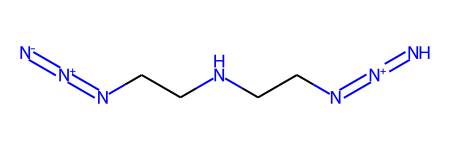

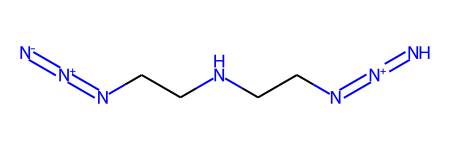

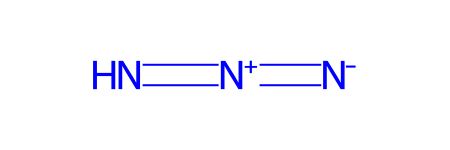

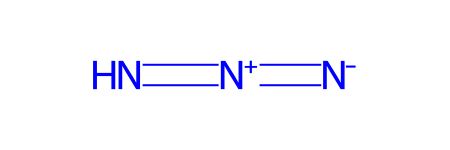

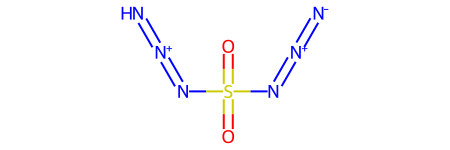

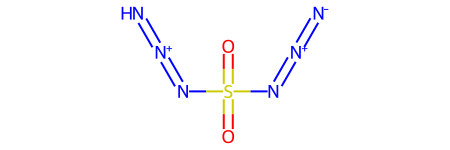

In [71]:
# visually check what was failed to generate
for mol in failed_to_generate:
    mol = Chem.MolFromSmiles(mol)
    AllChem.Compute2DCoords(mol)
    display(mol)

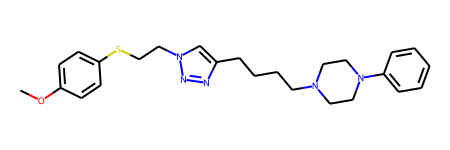

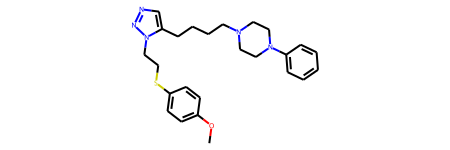

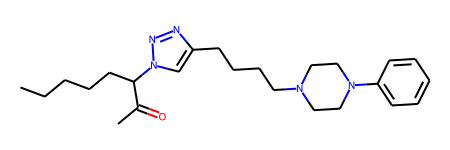

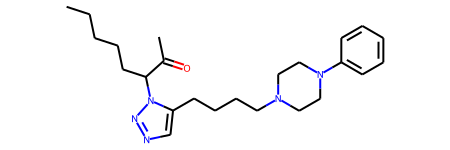

In [72]:
# visualize some sample molecules
sample_mols = [Chem.MolFromSmiles(reaction_products[i][0]) for i in [374, 375, 110, 111]]

for mol in sample_mols:
    AllChem.Compute2DCoords(mol)
    display(mol)

<a id='section3'></a>
## Add logBB and permeability groups:

In [68]:
# function to calculate Clark and Riston logBB
def logBB(logp, psa):
    clark = 0.152*(float(logp)) - 0.0148*(float(psa)) + 0.139 # this will calculate empirical Clark's logBB (blood/brain partition coefficient)
    riston = 0.155*(float(logp)) - 0.01*(float(psa)) + 0.164 # this will calculate empirical Rishton's logBB (blood/brain partition coefficient)
    return [clark, riston]

# a function to define permeability group
def logBB_group(logbb):
    if logbb >= 0.3:
        return 1
    elif logbb <= -1: 
        return -1
    else:
        return 0

In [73]:
for i in tqdm(range(len(reaction_products)), desc="calculating logBB"):
    mol = Chem.MolFromSmiles(reaction_products[i][0])
    logp, psa = Chem.rdMolDescriptors.CalcCrippenDescriptors(mol)[0], Descriptors.TPSA(mol)
    
    logbb = logBB(logp, psa)
    reaction_products[i].extend(logbb)
    reaction_products[i].extend([logBB_group(logbb[0]), logBB_group(logbb[1])])

<a id='section4'></a>
## Add tanimoto similatiry

In [75]:
# define eticlopride and scaffold molecules and calculate their bit fingerpints
scaffold = Chem.MolFromSmiles('N1N=NC=C1CCCCN1CCN(CC1)C1=CC=CC=C1')
eticlopride = Chem.MolFromSmiles('CCC1=CC(=C(C(=C1O)C(=O)NCC2CCCN2CC)OC)Cl')

scaf = rdMolDescriptors.GetMorganFingerprintAsBitVect(scaffold, radius=2)
epq  = rdMolDescriptors.GetMorganFingerprintAsBitVect(eticlopride, radius=2)

def calculate_tanimoto(smi, ref):
    mol = Chem.MolFromSmiles(smi)
    fp_mol = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2)
    return DataStructs.cDataStructs.TanimotoSimilarity(fp_mol, ref)

for i in tqdm(range(len(reaction_products)), desc="calculating Tanimoto similarity"):
    mol = reaction_products[i][0]
    reaction_products[i].append(calculate_tanimoto(mol, scaf))
    reaction_products[i].append(calculate_tanimoto(mol, epq))

calculating Tanimoto similarity: 100%|██████████| 18838/18838 [00:09<00:00, 1916.63it/s]


In [77]:
reaction_products[0]

['COCCOCCOCC(=O)n1cc(CCCCN2CCN(c3ccccc3)CC2)nn1',
 1,
 -0.8089544,
 -0.385366,
 0,
 0,
 0.4,
 0.14285714285714285]

<a id='section5'></a>
## Create and save dataframe

In [78]:
# create dataframe
data = pd.DataFrame(data=reaction_products, 
                    columns = ['smiles', 'is_14isomer', 'logBBclark', 'logBBrishton', 'group_clark', 'group_rishton', 'scaf_tanimoto', 'epq_tanimoto'])

print(data.shape)
data.head()

(18838, 8)


,smiles,is_14isomer,logBBclark,logBBrishton,group_clark,group_rishton,scaf_tanimoto,epq_tanimoto
0,COCCOCCOCC(=O)n1cc(CCCCN2CCN(c3ccccc3)CC2)nn1,1,-0.808954,-0.385366,0,0,0.400000,0.142857
1,COCCOCCOCC(=O)n1nncc1CCCCN1CCN(c2ccccc2)CC1,0,-0.808954,-0.385366,0,0,0.444444,0.142857
2,COC(=O)C(O)C(C)n1cc(CCCCN2CCN(c3ccccc3)CC2)nn1,1,-0.869335,-0.437926,0,0,0.400000,0.142857
3,COC(=O)C(O)C(C)n1nncc1CCCCN1CCN(c2ccccc2)CC1,0,-0.869335,-0.437925,0,0,0.444444,0.142857
4,CSCCC(NCCCn1cc(CCCCN2CCN(c3ccccc3)CC2)nn1)C(N)=O,1,-0.921714,-0.447596,0,0,0.351351,0.107843


In [82]:
# create id
data = data.reset_index()
data = data.rename(columns = {'index':'id'}, inplace = False)
data['id'] = data['id'] + 1
data.head()

,id,smiles,is_14isomer,logBBclark,logBBrishton,group_clark,group_rishton,scaf_tanimoto,epq_tanimoto
0,1,COCCOCCOCC(=O)n1cc(CCCCN2CCN(c3ccccc3)CC2)nn1,1,-0.808954,-0.385366,0,0,0.400000,0.142857
1,2,COCCOCCOCC(=O)n1nncc1CCCCN1CCN(c2ccccc2)CC1,0,-0.808954,-0.385366,0,0,0.444444,0.142857
2,3,COC(=O)C(O)C(C)n1cc(CCCCN2CCN(c3ccccc3)CC2)nn1,1,-0.869335,-0.437926,0,0,0.400000,0.142857
3,4,COC(=O)C(O)C(C)n1nncc1CCCCN1CCN(c2ccccc2)CC1,0,-0.869335,-0.437925,0,0,0.444444,0.142857
4,5,CSCCC(NCCCn1cc(CCCCN2CCN(c3ccccc3)CC2)nn1)C(N)=O,1,-0.921714,-0.447596,0,0,0.351351,0.107843


In [84]:
# also let's check if any rows contain Nans
data[data.isna().any(axis = 1)]

,id,smiles,is_14isomer,logBBclark,logBBrishton,group_clark,group_rishton,scaf_tanimoto,epq_tanimoto


In [85]:
# save generated dataset
data.to_csv('data/click_compunds_dataset.csv')

<a id='section6'></a>
## Exploratory analysis  
**logBB, groups and tanimoto similarity distribution**

In [5]:
# reload data
data = pd.read_csv('data/click_compunds_dataset.csv', index_col=0)
data

,id,smiles,is_14isomer,logBBclark,logBBrishton,group_clark,group_rishton,scaf_tanimoto,epq_tanimoto
0,1,COCCOCCOCC(=O)n1cc(CCCCN2CCN(c3ccccc3)CC2)nn1,1,-0.808954,-0.385366,0,0,0.400000,0.142857
1,2,COCCOCCOCC(=O)n1nncc1CCCCN1CCN(c2ccccc2)CC1,0,-0.808954,-0.385366,0,0,0.444444,0.142857
2,3,COC(=O)C(O)C(C)n1cc(CCCCN2CCN(c3ccccc3)CC2)nn1,1,-0.869335,-0.437926,0,0,0.400000,0.142857
3,4,COC(=O)C(O)C(C)n1nncc1CCCCN1CCN(c2ccccc2)CC1,0,-0.869335,-0.437925,0,0,0.444444,0.142857
4,5,CSCCC(NCCCn1cc(CCCCN2CCN(c3ccccc3)CC2)nn1)C(N)=O,1,-0.921714,-0.447596,0,0,0.351351,0.107843
...,...,...,...,...,...,...,...,...,...
18833,18834,CCc1cccc(OCCn2nncc2CCCCN2CCN(c3ccccc3)CC2)c1,0,0.069773,0.329782,0,1,0.453125,0.115789
18834,18835,CCC(=O)n1ccnc1-n1cc(CCCCN2CCN(c3ccccc3)CC2)nn1,1,-0.523631,-0.144670,0,0,0.393939,0.117021
18835,18836,CCC(=O)n1ccnc1-n1nncc1CCCCN1CCN(c2ccccc2)CC1,0,-0.523631,-0.144670,0,0,0.430769,0.127660
18836,18837,CN1CCC(Cl)(Cn2cc(CCCCN3CCN(c4ccccc4)CC3)nn2)C1=O,1,-0.368070,-0.060281,0,0,0.400000,0.094737


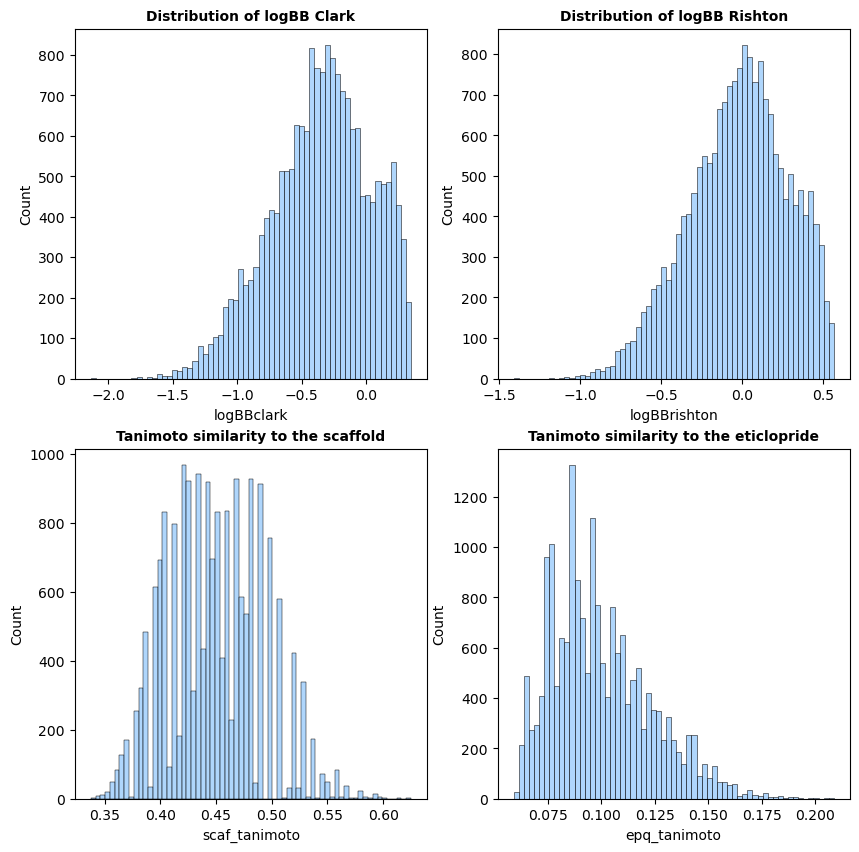

In [16]:
# view descriptor destributions
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

titles = ['Distribution of logBB Clark', 'Distribution of logBB Rishton',
          'Tanimoto similarity to the scaffold', 'Tanimoto similarity to the eticlopride']
cols = ['logBBclark', 'logBBrishton', 'scaf_tanimoto', 'epq_tanimoto']

for i, (title, col) in enumerate(zip(titles, cols)):
    sns.histplot(data[col], color = '#95c9fc', ax=axes[i], label=col)
    axes[i].set_title(title, fontsize=10, weight='bold')
    plt.grid()

# plt.savefig('dataset_features_distributions.png', bbox_inches='tight', dpi=300)
plt.show()

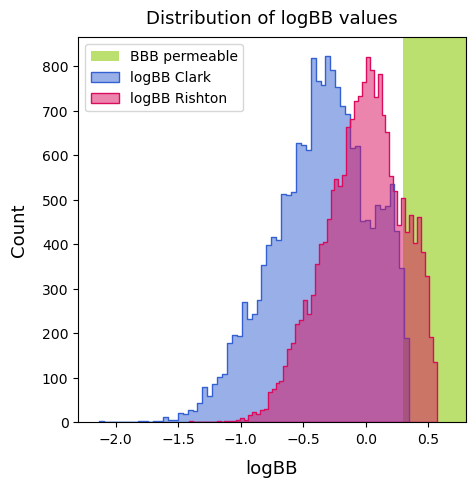

In [76]:
# compare destributions of logBB values 

plt.figure(figsize=(5, 5))

plt.axvspan(0.3, 0.8, facecolor='#9fd432', alpha=0.7, label='BBB permeable')

sns.histplot(data['logBBclark'], color = '#3461d2', label='logBB Clark', element="step", alpha=0.5)
sns.histplot(data['logBBrishton'], color = '#da0c5e', label='logBB Rishton', element="step", alpha=0.5)

plt.xlim(-2.3, 0.8)

plt.ylabel('Count', fontsize=13, labelpad=10)
plt.xlabel('logBB', fontsize=13, labelpad=10)
plt.title("Distribution of logBB values", fontsize=13, pad=10)

plt.legend(loc='upper left')

# plt.savefig('logBB_distribution.png', bbox_inches='tight', dpi=300)
plt.show()

In [95]:
print(f"There are {data[data['group_clark'] == 1].shape[0]} compounds with logBB Clark > 0.3")
print(f"There are {data[data['group_rishton'] == 1].shape[0]} compounds with logBB Rishton > 0.3")

There are 230 compounds with logBB Clark > 0.3
There are 3062 compounds with logBB Rishton > 0.3


**All clark coumpounds are included within rishton compounds:**

In [96]:
data[(data['group_rishton'] == 1) & data['group_clark'] == 1].shape[0]

230

### Check that all structures are generated correctly

In [99]:
# reference structure 
scaffold = Chem.MolFromSmiles('N1N=NC=C1CCCCN1CCN(CC1)C1=CC=CC=C1')
AllChem.Compute2DCoords(scaffold)
scaffold

damaged_mols_ids = []
damaged_mols = []

for i in tqdm(data.index):
    mol = data.loc[i, 'smiles']
    mol = Chem.MolFromSmiles(mol)
    try:
        AllChem.GenerateDepictionMatching2DStructure(mol, scaffold)
    except:
        # in case no matching to scaffold was observed
        damaged_mols.append(mol)
        damaged_mols_ids.append(old_data.loc[i, 'id'])
        
print(f"Found {len(damaged_mols)} damaged molecules ({len(damaged_mols)*100/len(data['smiles'])}% of all molecules)")

100%|██████████| 18838/18838 [00:06<00:00, 2986.20it/s]

Found 0 damaged molecules (0.0% of all molecules)


### Plot number of rotatabble bonds in library

In [4]:
rotatable_bonds_count = defaultdict(int)

def count_ritatable_bonds(smi):
    n_rb = rdMolDescriptors.CalcNumRotatableBonds(Chem.MolFromSmiles(smi))
    rotatable_bonds_count[n_rb] += 1
    
data['smiles'].apply(lambda x: count_ritatable_bonds(x))

0        None
1        None
2        None
3        None
4        None
         ... 
18833    None
18834    None
18835    None
18836    None
18837    None
Name: smiles, Length: 18838, dtype: object

In [5]:
rotatable_bonds_count

defaultdict(int,
            {14: 478,
             9: 3652,
             15: 294,
             11: 2008,
             13: 812,
             12: 1354,
             8: 3862,
             10: 2832,
             7: 3144,
             6: 184,
             16: 114,
             19: 16,
             17: 64,
             18: 24})

In [8]:
# calculate the ration of compound with 5 to 10 rotatable bonds
s = 0
for k in rotatable_bonds_count:
    s += rotatable_bonds_count[k]

m = 0
for i in range(5, 11):
    m += rotatable_bonds_count[i]
    
m / s * 100

72.58732349506317

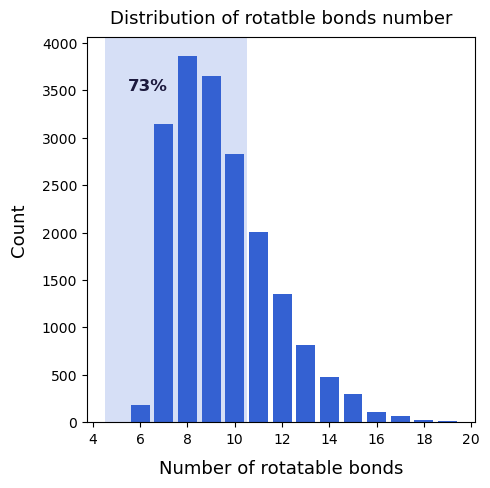

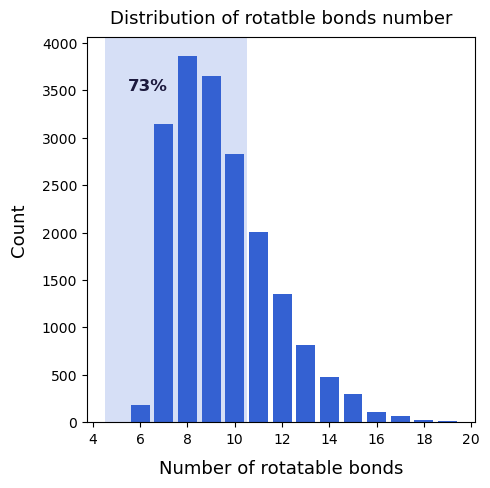

In [54]:
plt.subplots(figsize=(5, 5))

plt.axvspan(4.5, 10.5, facecolor='#3461d2', alpha=0.2)

plt.bar(rotatable_bonds_count.keys(), rotatable_bonds_count.values(), color='#3461d2')

plt.text(5.5, 3500, '73%', color='#1c193d', weight='bold', fontsize=12)

plt.ylabel('Count', fontsize=13, labelpad=10)
plt.xlabel('Number of rotatable bonds', fontsize=13, labelpad=10)
plt.title("Distribution of rotatble bonds number", fontsize=13, pad=10)

# plt.savefig('rotatable_bonds.png', bbox_inches='tight', dpi=300)
plt.show()

<a id='section7'></a>
## logBB for eticlopride for reference

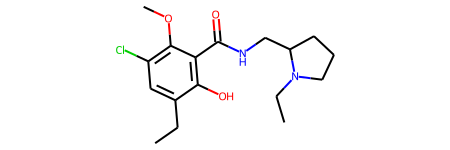

In [86]:
epq = Chem.MolFromSmiles('CCC1=CC(=C(C(=C1O)C(=O)NCC2CCCN2CC)OC)Cl')
epq

In [88]:
logp, psa = Chem.rdMolDescriptors.CalcCrippenDescriptors(epq)[0], Descriptors.TPSA(epq)
clark, rishton = logBB(logp, psa)
print(f'Clark logBB is {clark}, rishton logBB {rishton}')

Clark logBB is -0.34537359999999984, rishton logBB -0.015241499999999825


**All rishton and clark compounds in group 1 should be permeable for the membrane**